In [ ]:
using OptimalControl
using MINPAC

## Direct solve

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.


EXIT: Problem has inconsistent variable bounds or constraint sides.


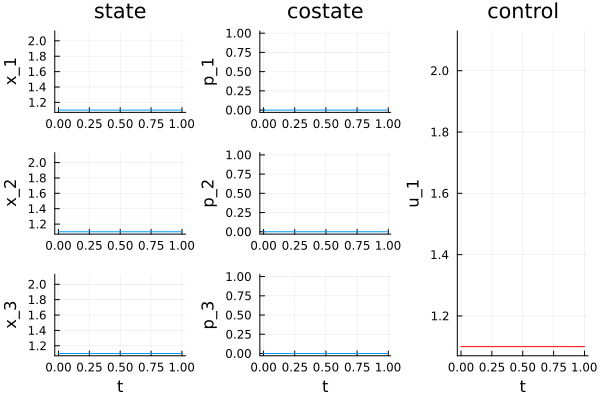

In [2]:
# Parameters
Cd = 310.
Tmax = 3.5
β = 500.
b = 2.
t0 = 0.
r0 = 1.
v0 = 0.
vmax = 0.1
m0 = 1.
mf = 0.6
x0 = [ r0, v0, m0 ]

ocp = Model()

time!(ocp, :initial, t0) # if not provided, final time is free
state!(ocp, 3) # state dim
control!(ocp, 1) # control dim

constraint!(ocp, :initial, x0) # vectorial equality
constraint!(ocp, :control, u -> u[1], 0., 1.) # constraints can be labeled or not
constraint!(ocp, :state, (x, u) -> x[1], r0, Inf, :state_con1)
constraint!(ocp, :state, (x, u) -> x[2], 0., vmax, :state_con2)
constraint!(ocp, :state, (x, u) -> x[3], m0, mf, :state_con3)

objective!(ocp, :mayer,  (t0, x0, tf, xf) -> xf[1], :max)

function F0(x)
    r, v, m = x
    D = Cd * v^2 * exp(-β*(r-1.))
    F = [ v, -D/m-1.0/r^2, 0. ]
    return F
end

function F1(x)
    r, v, m = x
    F = [ 0., Tmax/m, -b*Tmax ]
    return F
end

function f(x, u)
    return F0(x) + u*F1(x)
end

constraint!(ocp, :dynamics, f)

sol = solve(ocp)
plot(sol)

## Indirect solve

In [ ]:
function Ad(X, f)
    return x -> ∇(f, x)'*X(x)
end
function Poisson(f, g)
    function fg(x, p)
        n = size(x, 1)
        ff = z -> f(z[1:n], z[n+1:2n])
        gg = z -> g(z[1:n], z[n+1:2n])
        df = ∇(ff, [ x ; p ])
        dg = ∇(gg, [ x ; p ])
        return df[n+1:2n]'*dg[1:n] - df[1:n]'*dg[n+1:2n]
    end
    return fg
end

In [ ]:
# Bang controls
u0(x, p) = 0.
u1(x, p) = 1.

# Computation of singular control of order 1
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)
H01 = Poisson(H0, H1)
H001 = Poisson(H0, H01)
H101 = Poisson(H1, H01)
us(x, p) = -H001(x, p) / H101(x, p)

# Computation of boundary control
remove_constraint!(ocp, :state_con1)
remove_constraint!(ocp, :state_con3)
constraint!(ocp, :boundary, (t0, x0, tf, xf) -> xf[3], mf, :final_con) # one value => equality (not boxed inequality); changed to equality constraint for shooting
#
g(x) = constraint(ocp, :state_con2, :upper)(x, 0.) # g(x, u) ≥ 0 (cf. nonnegative multiplier)
ub(x, _) = -Ad(F0, g)(x) / Ad(F1, g)(x)
μb(x, p) = H01(x, p) / Ad(F1, g)(x)

f0 = Flow(ocp, u0)
f1 = Flow(ocp, u1)
fs = Flow(ocp, us)
fb = Flow(ocp, ub, (x, _) -> g(x), μb)

# Shooting function
function shoot!(p0, t1, t2, t3, tf, s) # B+ S C B0 structure

    x1, p1 = f1(t0, x0, p0, t1)
    x2, p2 = fs(t1, x1, p1, t2)
    x3, p3 = fb(t2, x2, p2, t3)
    xf, pf = f0(t3, x3, p3, tf)
    s[1] = constraint(ocp, :final_con)(t0, x0, tf, xf)
    s[2:3] = pf[1:2] - [ 1.0, 0.0 ]
    s[4] = H1(x1, p1)
    s[5] = H01(x1, p1)
    s[6] = g(x2)
    s[7] = H0(xf, pf) # free tf

end

# Initialisation from direct solution
times = sol.T
x = [sol.X[i, 1:3] for i ∈ 1:length(times)]
p = [sol.P[i, 1:3] for i ∈ 1:length(times)]

H1_plot = plot(t, H1.(x, p), xlabel = "t", ylabel = "H1", legend = false)
g_plot = plot(t, g.(x), xlabel = "t", ylabel = "g", legend = false)
display(plot(u_plot, H1_plot, g_plot, layout = (3,1)))
η = 1e-3
t13 = t[ abs.(H1.(x, p)) .≤ η ]
t23 = t[ 0 .≤ g.(x) .≤ η ]
p0 = p[1]
t1 = min(t13...)
t2 = min(t23...)
t3 = max(t23...)
tf = t[end]
ξ0 = [ p0 ; t1 ; t2 ; t3 ; tf ]

println("Initial guess:\n", ξ)

# Solve
sol = fsolve((s, ξ) -> shoot!(s, ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7]), ξ0, show_trace=true); println(sol)

#= # Plots
p0 = sol.val[1:3]
t1 = sol.val[4]
t2 = sol.val[5]
t3 = sol.val[6]
tf = sol.val[7]

f = f1 @ (t1, fs) @ (t2, fb) @ (t3, f0) # composition of the four Hamiltonian flows

plot(f, (t0, x0, p0, tf)) =#